In [81]:
import tensorflow as tf
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
tf.__version__

'1.6.0'

In [9]:
a = tf.constant(2.3)
a

<tf.Tensor 'Const_3:0' shape=() dtype=float32>

In [10]:
b = tf.constant(3.4)
b

<tf.Tensor 'Const_4:0' shape=() dtype=float32>

In [11]:
c = a + b
c

<tf.Tensor 'add_1:0' shape=() dtype=float32>

In [12]:
with tf.Session() as sess:
    c_ = sess.run(c)
    print(c_)

5.7


In [41]:
tf.reset_default_graph()
a = tf.placeholder(dtype=tf.float32, shape=(), name="a")
b = tf.placeholder(dtype=tf.float32, shape=(), name="b")
print("a:", a, "\nb:", b)

c = a + b
print("c:", c)

with tf.Session() as sess:
    c_ = sess.run(c, feed_dict={a: 3.4, b: 2.3})
    print(c_)


a: Tensor("a:0", shape=(), dtype=float32) 
b: Tensor("b:0", shape=(), dtype=float32)
c: Tensor("add:0", shape=(), dtype=float32)
5.7


In [44]:
X_data = np.random.ranf((10, 4))
X_data

array([[0.2218215 , 0.33080264, 0.90506146, 0.81754645],
       [0.16477114, 0.70777903, 0.21215082, 0.88964454],
       [0.45341967, 0.75616083, 0.81574262, 0.54640309],
       [0.59271638, 0.86932407, 0.20830065, 0.84340189],
       [0.56983109, 0.75719139, 0.74323985, 0.99268976],
       [0.34607484, 0.99394657, 0.93786823, 0.21623269],
       [0.75390425, 0.84287561, 0.69695403, 0.14992141],
       [0.58169696, 0.12939281, 0.20638009, 0.16023984],
       [0.02812608, 0.66449123, 0.24479108, 0.12466182],
       [0.52731389, 0.81677366, 0.64103668, 0.02549855]])

In [47]:
W_data = np.random.ranf([4, 1])
W_data

array([[0.7452417 ],
       [0.81015546],
       [0.09259009],
       [0.90885362]])

In [48]:
X_data.dot(W_data)

array([[1.26014198],
       [1.5244051 ],
       [1.52264519],
       [1.93182004],
       [2.00913095],
       [1.34652181],
       [1.44548883],
       [0.70307643],
       [0.6952665 ],
       [1.13721804]])

In [50]:
tf.reset_default_graph()
X = tf.placeholder(dtype=tf.float32, shape=(None, 4), name="a")
W = tf.placeholder(dtype=tf.float32, shape=(4, 1), name="b")
print("X:", X, "\nW:", W)

Z = tf.matmul(X, W)
print("Z:", Z)

with tf.Session() as sess:
    Z_ = sess.run(Z, feed_dict={X: X_data, W: W_data})
    print(Z_)

X: Tensor("a:0", shape=(?, 4), dtype=float32) 
W: Tensor("b:0", shape=(4, 1), dtype=float32)
Z: Tensor("MatMul:0", shape=(?, 1), dtype=float32)
[[1.2601418 ]
 [1.5244051 ]
 [1.5226451 ]
 [1.9318202 ]
 [2.009131  ]
 [1.3465219 ]
 [1.4454888 ]
 [0.7030765 ]
 [0.69526654]
 [1.1372179 ]]


In [53]:
def load_data():
    df_train = pd.read_csv("/data/MNIST/mnist_train.csv", header=None)
    df_test = pd.read_csv("/data/MNIST/mnist_test.csv", header=None)
    y_train = df_train.iloc[:, 0].values
    X_train = df_train.iloc[:, 1:].values/255
    y_test = df_test.iloc[:, 0].values
    X_test = df_test.iloc[:, 1:].values/255
    return X_train, X_test, y_train, y_test 
X_train, X_test, y_train, y_test = load_data()

In [85]:
class Batchable(object):
    """
    Create a batchable object that would return batched X and y values.
    
    Usage:
    ....
    init = tf.global_variables_initializer()
    batchable = Batchable(X_train, y_train)
    with tf.Session() as sess:
    init.run()
    for i, progress, X_batch, y_batch in batchable.next():
        sess.run(opt, feed_dict={X: X_batch, y: y_batch})
        if i % (batchable.max_iters // 20) == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print("Progress:%3d%%" % progress, 
                  "Train accuracy: %.4f" % acc_train, 
                  "Test accuracy: %.4f" % acc_test)
    
    
    """
    
    def __shuffle(self):
        X = self.X
        y = self.y
        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        self.X = X[idx]
        self.y = y[idx]
        self.require_shuffle = False
        return
    
    def __init__(self, X, y, batch_size = 32, epochs = 10, seed = 1):
        
        if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
            raise ValueError('Both X and y must be np.ndarray')
        
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must be of same size of axis=0")
        
        from math import ceil
        np.random.seed(seed)
        self.X = X
        self.y = y
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_batches = ceil(X.shape[0] / batch_size)
        self.max_iters = self.epochs * self.num_batches
        self.__shuffle()
        
    def next(self):
        iteration, progress = 0, 0
        for i in range(self.epochs):
            self.current_epoch = i
            for j in range(self.num_batches):
                self.current_batch = j
                start = j * self.batch_size
                end = start + self.batch_size
                iteration = iteration + 1
                progress = int(100 * iteration / self.max_iters) + 1
                yield iteration, progress, self.X[start:end], self.y[start:end]
            self.__shuffle()


In [93]:
tf.reset_default_graph()
tf.set_random_seed(1)
n_x = 28 * 28
n_y = 10
n_h = 100
max_iters = 100

X = tf.placeholder(dtype=tf.float32, shape=(None, n_x), name = "X")
y = tf.placeholder(dtype=tf.int32, shape=(None), name = "y")

print("X", X)
print("y", y)

y_oh = tf.one_hot(y, depth=n_y)
print("y_oh", y_oh)


def dense(input, size, activation = tf.nn.relu):
    
    input_size = int(input.shape[1])
    W = tf.Variable(tf.truncated_normal(dtype=tf.float32
                                        , shape=(input_size, size)
                                        , stddev=0.1))
    print("W", W)

    b = tf.Variable(tf.zeros(shape=[size]))
    print("b", b)

    Z = tf.matmul(input, W) + b
    print("Z", Z)

    if callable(activation):
        Z = activation(Z)
        print("Activation", Z)
    return Z

A1 = dense(X, 400)
A2 = dense(A1, n_h)
Z = dense(A2, n_y, activation = None)

y_pred = tf.argmax(Z, axis=1, output_type=tf.int32)
print("y_pred", y_pred)

match = tf.equal(y, y_pred)
print("match", match)

accuracy = tf.reduce_mean(tf.cast(match, tf.float32))
print("accuracy", accuracy)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_oh, logits=Z))
print("cost", cost)

opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

init = tf.global_variables_initializer()


scores = {}

"""

with tf.Session() as sess:
    sess.run(init)
    
    for i in range(max_iters):
        _, cost_ = sess.run([opt, cost], feed_dict = {X: X_train, y: y_train})
        scores[i] = cost_
        if i == (max_iters//20) or i == max_iters - 1:
            train_accuracy_= sess.run(accuracy, feed_dict = {X: X_train, y: y_train})
            test_accuracy_= sess.run(accuracy, feed_dict = {X: X_test, y: y_test})
            print("train: %.4f, test: %.4f" % (train_accuracy_, test_accuracy_))
    pd.Series(scores).plot()
"""

batchable = Batchable(X_train, y_train, batch_size=32)
with tf.Session() as sess:
    init.run()
    for i, progress, X_batch, y_batch in batchable.next():
        sess.run(opt, feed_dict={X: X_batch, y: y_batch})
        if i % (batchable.max_iters // 20) == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print("Progress:%3d%%" % progress, 
                  "Train accuracy: %.4f" % acc_train, 
                  "Test accuracy: %.4f" % acc_test)


X Tensor("X:0", shape=(?, 784), dtype=float32)
y Tensor("y:0", dtype=int32)
y_oh Tensor("one_hot:0", dtype=float32)
W <tf.Variable 'Variable:0' shape=(784, 400) dtype=float32_ref>
b <tf.Variable 'Variable_1:0' shape=(400,) dtype=float32_ref>
Z Tensor("add:0", shape=(?, 400), dtype=float32)
Activation Tensor("Relu:0", shape=(?, 400), dtype=float32)
W <tf.Variable 'Variable_2:0' shape=(400, 100) dtype=float32_ref>
b <tf.Variable 'Variable_3:0' shape=(100,) dtype=float32_ref>
Z Tensor("add_1:0", shape=(?, 100), dtype=float32)
Activation Tensor("Relu_1:0", shape=(?, 100), dtype=float32)
W <tf.Variable 'Variable_4:0' shape=(100, 10) dtype=float32_ref>
b <tf.Variable 'Variable_5:0' shape=(10,) dtype=float32_ref>
Z Tensor("add_2:0", shape=(?, 10), dtype=float32)
y_pred Tensor("ArgMax:0", shape=(?,), dtype=int32)
match Tensor("Equal:0", dtype=bool)
accuracy Tensor("Mean:0", shape=(), dtype=float32)
cost Tensor("Mean_1:0", shape=(), dtype=float32)
Progress:  5% Train accuracy: 1.0000 Test accur

In [59]:
y_train

array([5, 0, 4, ..., 5, 6, 8])

In [62]:
eye = np.eye(10)
Y_train = eye[y_train]
pd.DataFrame(Y_train)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [94]:
import keras 

Using TensorFlow backend.


In [98]:
eye = np.eye(n_y)

In [103]:
n_y = 10
n_x = 28 * 28

def build_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=400, activation="relu", input_shape=(n_x,)))
    model.add(keras.layers.Dense(units=100, activation="relu", input_shape=(n_x,)))
    model.add(keras.layers.Dropout(rate=0.8))
    model.add(keras.layers.Dense(units=n_y, activation="softmax"))
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
    return model

model = build_model()
model.summary()
model.fit(x=X_train, y = eye[y_train], batch_size=32, epochs=10)
model.evaluate(X_test, eye[y_test])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 400)               314000    
_________________________________________________________________
dense_9 (Dense)              (None, 100)               40100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1010      
Total params: 355,110
Trainable params: 355,110
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
60000/60000 [==============================] - 16s 265us/step - loss: 0.5014 - acc: 0.8490
Epoch 2/10
60000/60000 [==============================] - 14s 242us/step - loss: 0.2363 - acc: 0.9349
Epoch 3/10
60000/60000 [==============================] - 15s 25

[0.10669537619699195, 0.9779]

In [117]:
y_test_pred = np.argmax(model.predict(X_test), axis=1)

In [110]:
y_test_pred.shape

(10000,)

In [106]:
import matplotlib.pyplot as plt

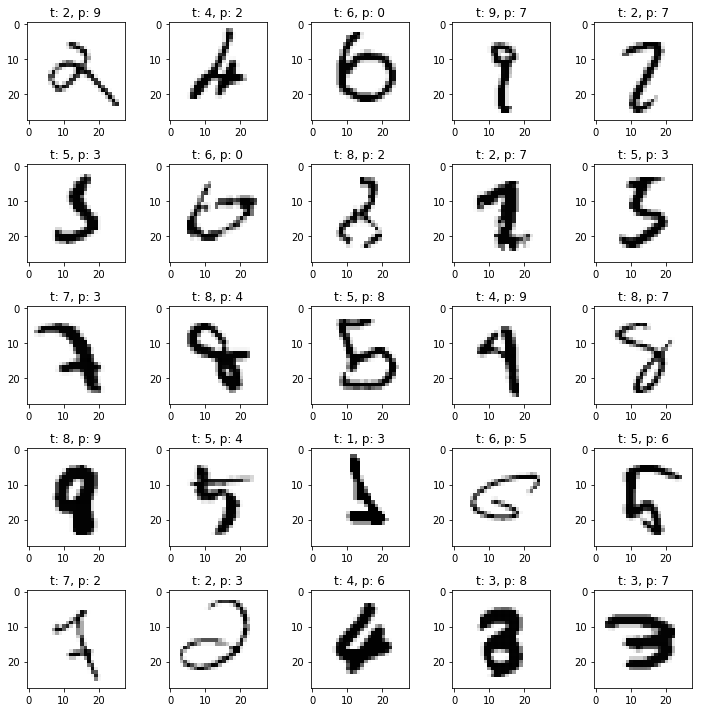

In [118]:
wrong = y_test != y_test_pred
fig, _ = plt.subplots(5, 5, figsize = (10, 10))

for i, ax in enumerate(fig.axes):
    ax.imshow(X_test[wrong][i].reshape(28, 28), cmap = "Greys")
    ax.set_title("t: %d, p: %d" % (y_test[wrong][i], y_test_pred[wrong][i]))

plt.tight_layout()

In [112]:
model.to_json()

'{"class_name": "Sequential", "config": [{"class_name": "Dense", "config": {"name": "dense_8", "trainable": true, "batch_input_shape": [null, 784], "dtype": "float32", "units": 400, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_9", "trainable": true, "batch_input_shape": [null, 784], "dtype": "float32", "units": 100, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "

In [114]:
model.save_weights("mnist_weights")

In [115]:
model.save("mnist.h5")

In [116]:
model = keras.models.load_model("mnist.h5")